In [1]:
#step 1
#import modules
import model
import preprocessing as pre
import get_data
import cv2
from matplotlib import pyplot as plt
import random
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import keras.backend as K
import pandas as pd
import predict
import os
from keras.optimizers import Adam, SGD
import process as pro
import split_data
import visualize as v


In [2]:
#step 2
#dataset directory & preprocessed dataset directory
data_dir = 'dataset/input/insects'
preprocessed_dir = 'dataset/preprocessed_input'

In [3]:
#step 3
labels = get_data.get_labels(data_dir)
IMG_SIZE = 224

In [ ]:
#sync.synchronize_data(preprocessed_dir, labels)

(213, 236)


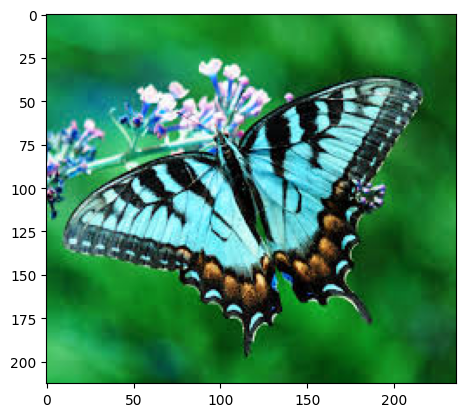

In [4]:
test_img = cv2.imread(data_dir+'/Butterfly/Butterfly_20.jpg')
plt.imshow(test_img)
print(test_img.shape[:2])

(224, 224)


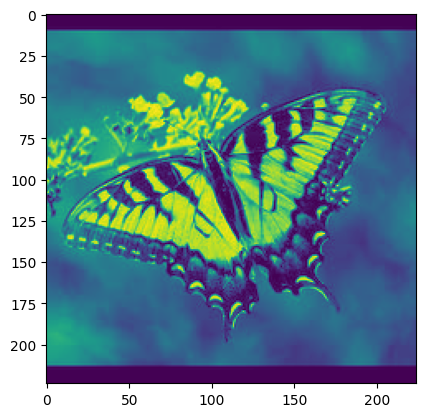

In [5]:
test_result = pre.preprocessing_image(test_img)
plt.imshow(test_result)
print(test_result.shape)

In [4]:
#save preprocessed data
print('Preprocessing Progress')
pro.preprocess_progress(data_dir, preprocessed_dir, labels)

Preprocessing Progress


Preprocessed Image: 100%|██████████| 600/600 [01:59<00:00,  5.01it/s]

Preprocess and rotation data has been completed


In [ ]:
#step 4
#rotate each images in preprocessed data into 3 new images (rotate 90 degree, 180 degree and 270 degree)
#print('Rotate Progress')
#o.rotate_progress(preprocessed_dir, labels)
        
#synchronize data in preprocess data folder
print('Synchronize Progress')
pro.synchronize_progress(preprocessed_dir, labels)

In [5]:
#step 5
from itertools import chain
dataset_len = get_data.get_data(preprocessed_dir, labels)[1]
sample_len = 0
num_samples = 40
data_lists = []
while sample_len < dataset_len:
    data_lists.append(get_data.get_random_data(preprocessed_dir, labels, num_samples)[0])
    sample_len += get_data.get_random_data(preprocessed_dir, labels, num_samples)[1]
print(sample_len)
#change multiple sample lists into 1 list
data = list(chain.from_iterable(data_lists))

7200


In [6]:
#step 6
#import class mapping
l = []
for i in data:
    l.append(labels[i[1]])

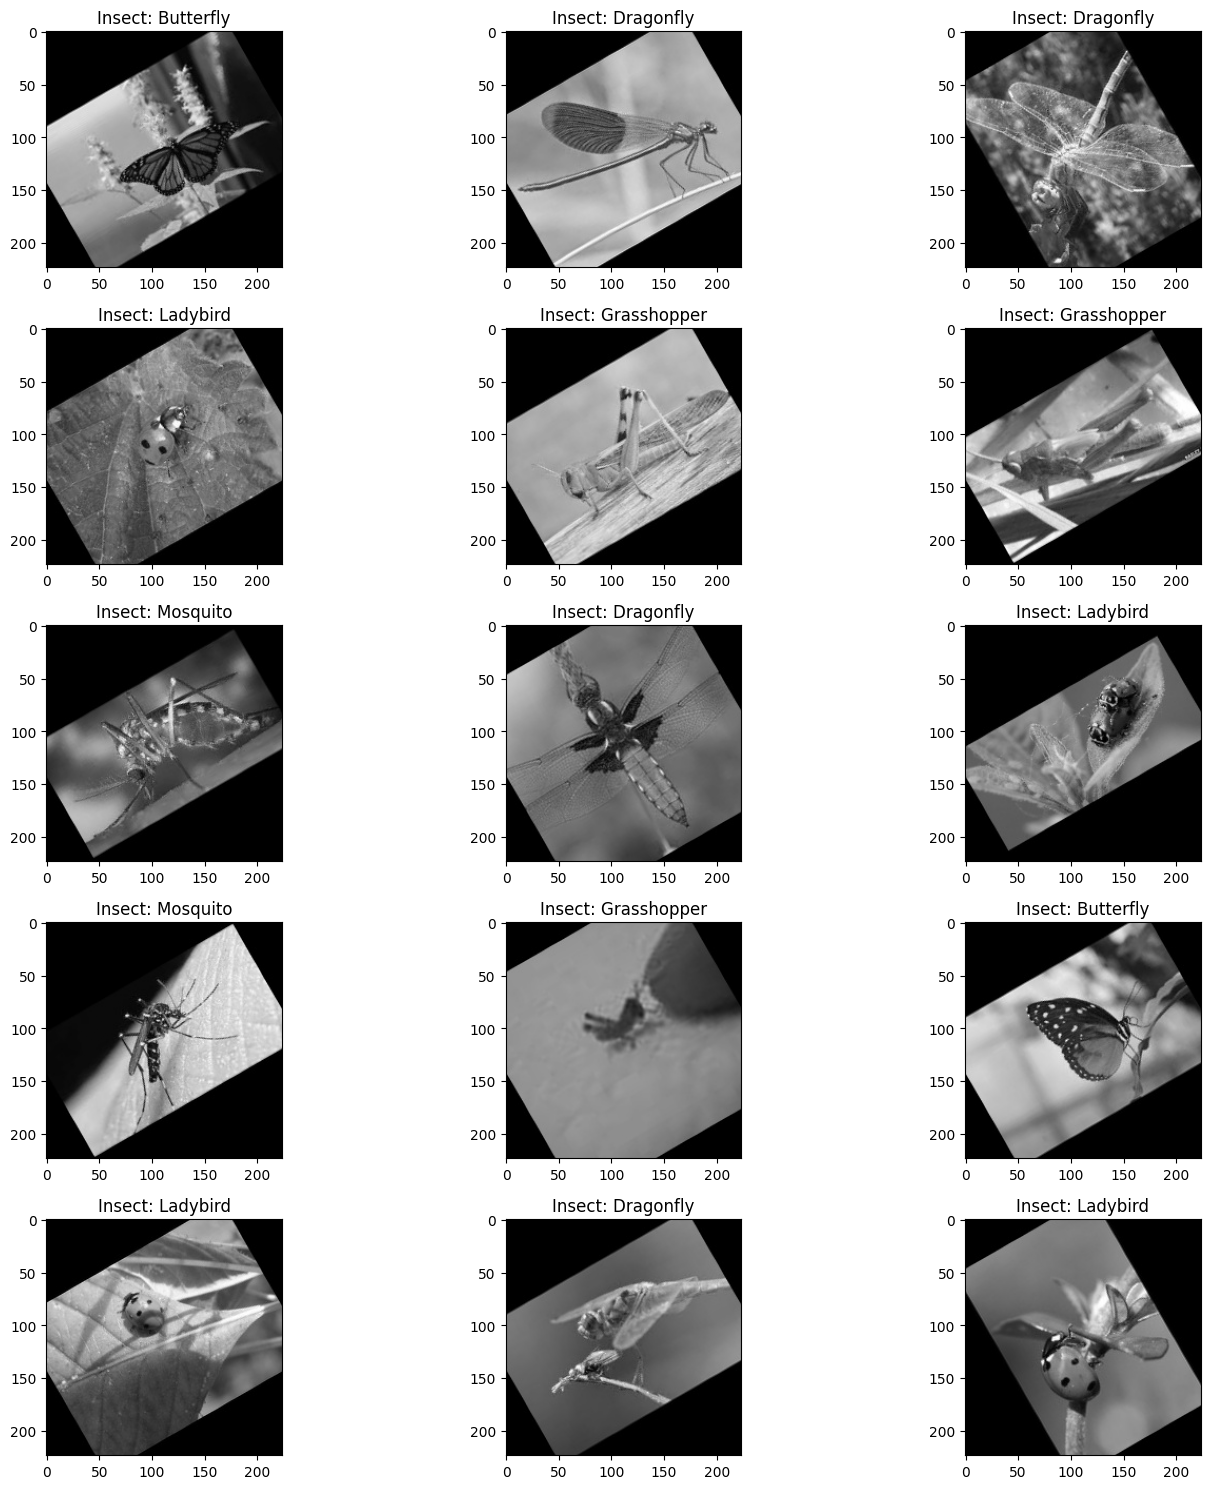

In [7]:
#step 7
#show 15 samples
fig,ax=plt.subplots(5,3)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (3):
        l=random.randint(0,len(data))
        ax[i,j].imshow(data[l][0][:,:,::-1])
        ax[i,j].set_title('Insect: '+labels[data[l][1]])

plt.tight_layout()

In [8]:
#step 8
x = []
y = []
# x array is set of image features
# y array is set of labels 
for feature, label in data:
    x.append(feature)
    y.append(label)

In [9]:
#step 9
# Normalize the data
x = np.array(x)
y = np.array(y)

In [10]:
#step 10
#divide data into 3 parts with the ratios
#training = 0.6, validation = 0.2, testing = 0.2
train_ratio = 0.6
valid_ratio = 0.2
test_ratio = 0.2

image_train_val, image_test, label_train_val, label_test = train_test_split(x, y, test_size=test_ratio,  stratify = y , random_state = 0)
remaining_ratio = valid_ratio / (train_ratio + valid_ratio)
image_train, image_val, label_train, label_val = train_test_split(image_train_val, label_train_val, test_size=remaining_ratio, stratify=label_train_val, random_state=0)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


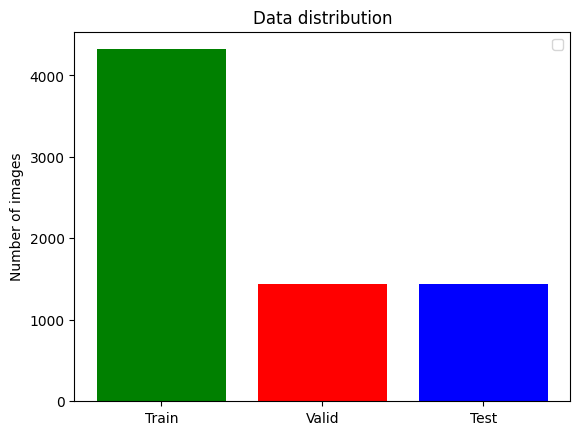

In [11]:
v.show_train_test_distribution_3_parts(image_train, image_val, image_test)

In [12]:
#step 11
del x,y,data

In [13]:
#step 12
#build VGG19 model to train data
#model = model.build_VGG19(IMG_SIZE)
#build ResNet101V2
#model = model.build_ResNet101V2(IMG_SIZE)
#build RetinaNet
#model = model.build_RetinaNet(IMG_SIZE)
# build ResNet101V2 with Attention
model = model.build_ResNet101V2_Attention(IMG_SIZE)


#optimizer = SGD(momentum=0.9)
model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

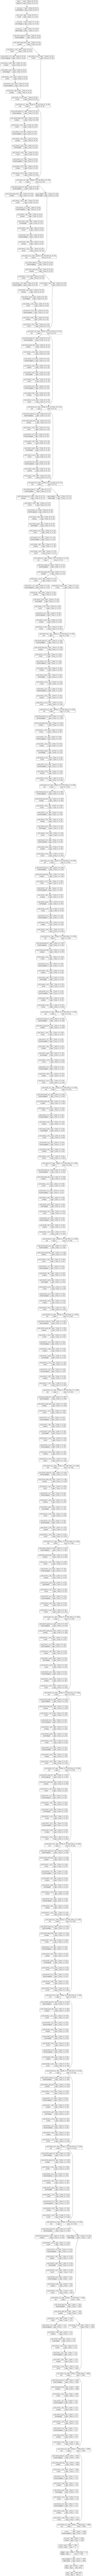

In [14]:
#step 13
from keras.utils import plot_model
#show plot model
plot_model(model,
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True,
           rankdir = 'TB',
           expand_nested = False,
           dpi = 70)

In [15]:
#step 14
#log file & saved model file directory
log_dir= 'training4.log'
model_dir= 'model4.h5'

In [16]:
#step 15
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import CSVLogger
# setup callbacks and log saving
csv_logger = CSVLogger(log_dir, separator = ',', append = False)
learning_rate_reduction = [ReduceLROnPlateau(monitor='val_loss',
                                                             patience = 2, verbose=1,factor=0.2, min_lr=1e-12),
                           csv_logger]


In [17]:
#step 16
epoch = 100

K.clear_session()

model.fit(image_train, label_train, batch_size = 64 , epochs = epoch , validation_data = (image_val, label_val), callbacks = [learning_rate_reduction])
model.save(model_dir)


Epoch 1/100
68/68 [==============================] - 2311s 34s/step - loss: 0.6424 - accuracy: 0.8106 - val_loss: 193.8118 - val_accuracy: 0.2278 - lr: 0.0010
Epoch 2/100
68/68 [==============================] - 2257s 33s/step - loss: 0.1783 - accuracy: 0.9463 - val_loss: 5.6578 - val_accuracy: 0.3958 - lr: 0.0010
Epoch 3/100
68/68 [==============================] - 2251s 33s/step - loss: 0.0789 - accuracy: 0.9789 - val_loss: 3.3811 - val_accuracy: 0.7181 - lr: 0.0010
Epoch 4/100
68/68 [==============================] - 2247s 33s/step - loss: 0.0881 - accuracy: 0.9745 - val_loss: 2.1759 - val_accuracy: 0.5660 - lr: 0.0010
Epoch 5/100
68/68 [==============================] - 2246s 33s/step - loss: 0.0478 - accuracy: 0.9850 - val_loss: 0.3230 - val_accuracy: 0.9153 - lr: 0.0010
Epoch 6/100
68/68 [==============================] - 2260s 33s/step - loss: 0.0201 - accuracy: 0.9944 - val_loss: 0.7831 - val_accuracy: 0.8389 - lr: 0.0010
Epoch 7/100
68/68 [==============================] - ETA

In [ ]:
# try this code to continue to train when you have log file and model file
# when you go on training model, you needn't to execute above block of code
'''
model = tf.keras.models.load_model(model_dir, compile = False)


log_file_path = log_dir
with open(log_file_path, 'r') as f:
    log_data = f.readlines()

loss_values = []
accuracy_values = []

for line in log_data:
    if 'Epoch' in line and 'loss:' in line and 'accuracy:' in line:
        epoch = int(line.split('Epoch ')[-1].split(' -')[0])
        loss = float(line.split('loss: ')[-1].split(' -')[0])
        accuracy = float(line.split('accuracy: ')[-1].strip())
        loss_values.append(loss)
        accuracy_values.append(accuracy)

initial_epoch = len(loss_values)
epoch2 = initial_epoch + 25
model.compile(optimizer='adam',loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

csv_logger = CSVLogger(log_dir, separator = ',', append = True)
learning_rate_reduction = [keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                             patience = 2, verbose=1,factor=0.2, min_lr=0.00000001),
                           csv_logger]
K.clear_session()

model.fit(image_train, label_train, initisl_epoch=initial_epoch, batch_size = 64 , epochs = epoch , validation_data = (image_val, label_val), callbacks = [learning_rate_reduction])
model.save(model_dir)
'''

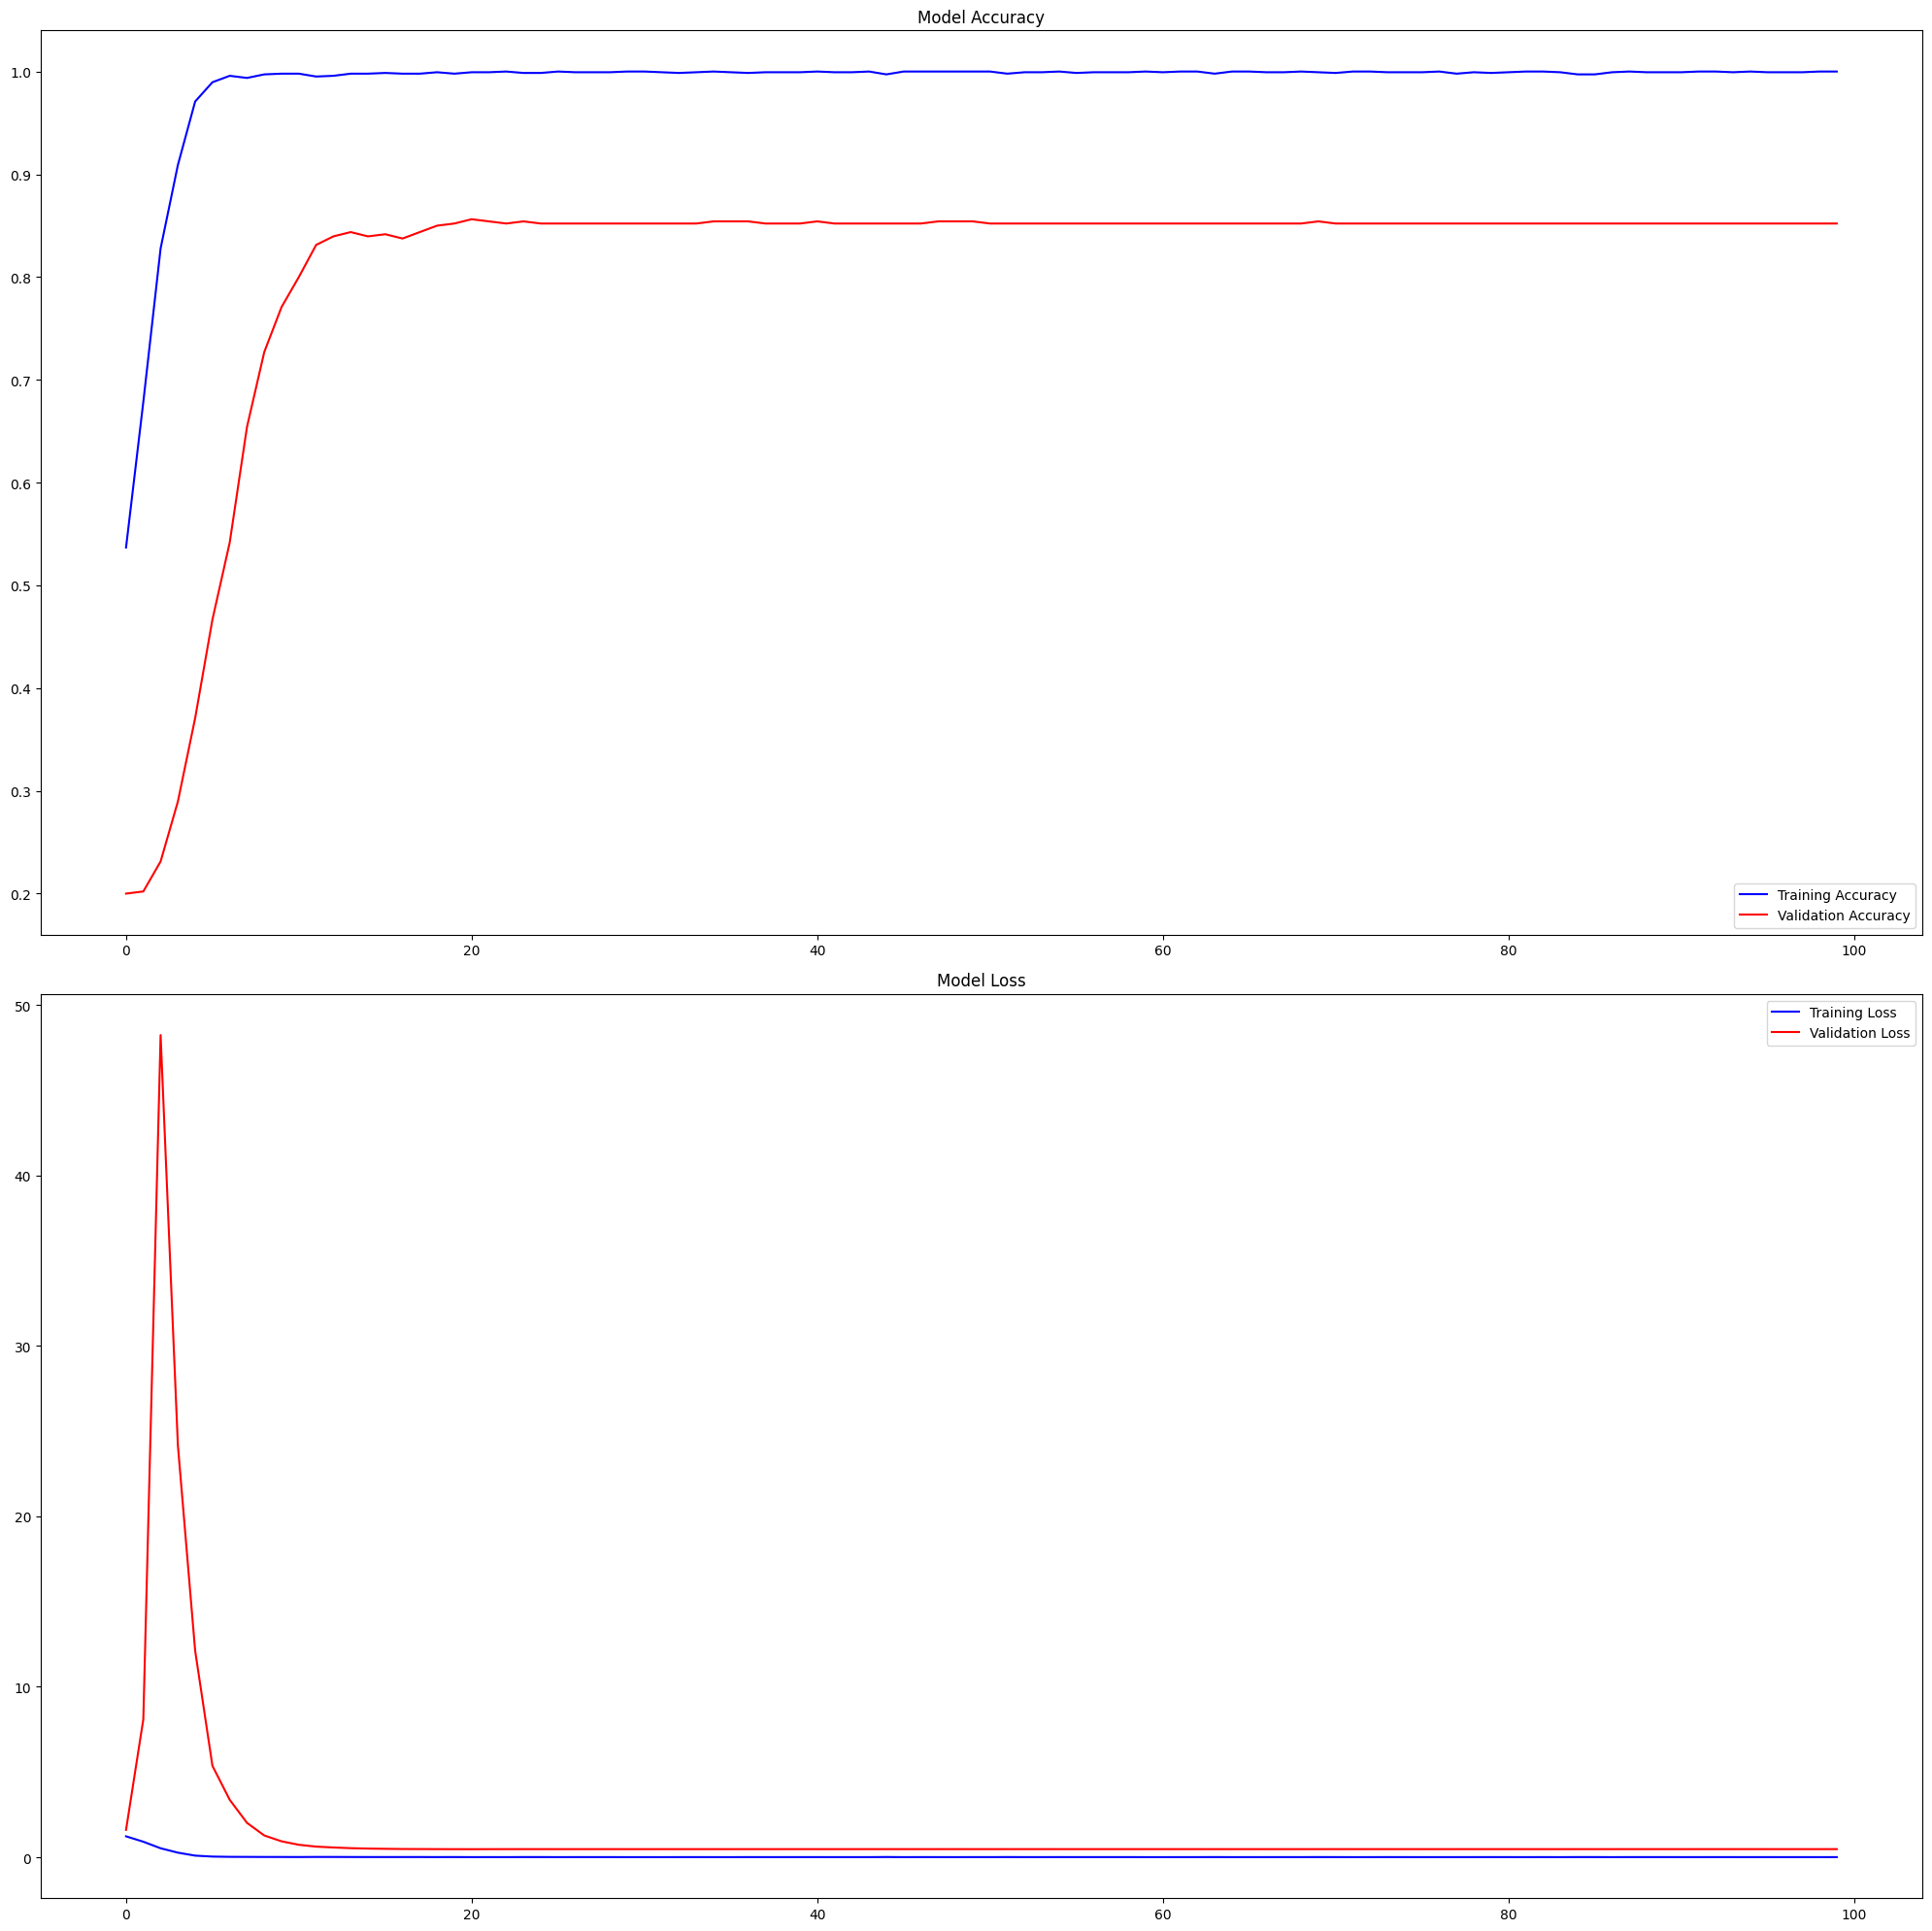

In [20]:
#step 18
v.show_train_result(model_dir, log_dir)

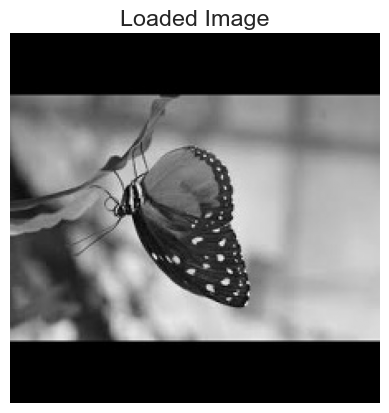

1/1 [==============================] - 3s 3s/step


Maximum Probability:  0.99695635
Classified: Butterfly 



-------------------Individual Probability--------------------------------

BUTTERFLY : 99.7 %
DRAGONFLY : 0.3 %
GRASSHOPPER : 0.0 %
LADYBIRD : 0.01 %
MOSQUITO : 0.0 %


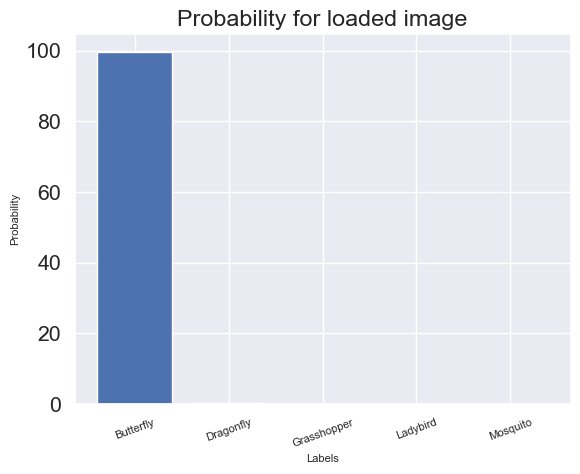


--------------------------------------------------------------------------



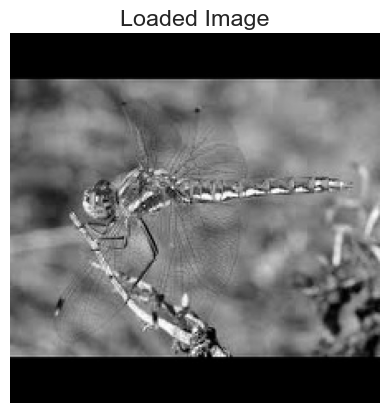

1/1 [==============================] - 0s 156ms/step


Maximum Probability:  0.997139
Classified: Dragonfly 



-------------------Individual Probability--------------------------------

BUTTERFLY : 0.24 %
DRAGONFLY : 99.71 %
GRASSHOPPER : 0.02 %
LADYBIRD : 0.03 %
MOSQUITO : 0.0 %


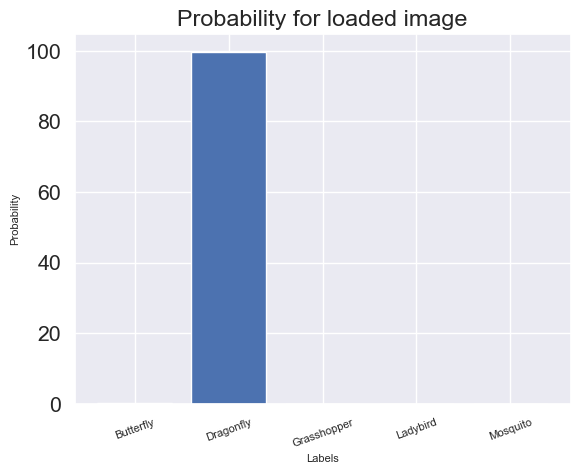


--------------------------------------------------------------------------



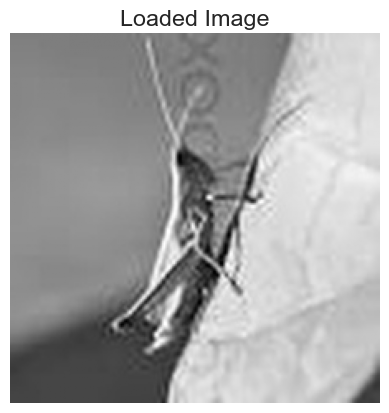

1/1 [==============================] - 0s 170ms/step


Maximum Probability:  0.91674757
Classified: Mosquito 



-------------------Individual Probability--------------------------------

BUTTERFLY : 0.07 %
DRAGONFLY : 0.75 %
GRASSHOPPER : 7.5 %
LADYBIRD : 0.0 %
MOSQUITO : 91.67 %


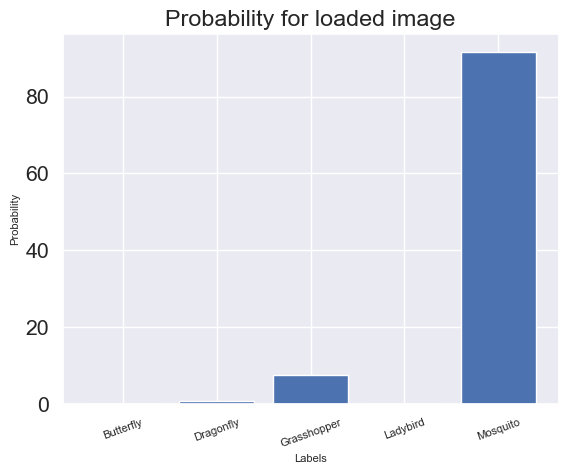


--------------------------------------------------------------------------



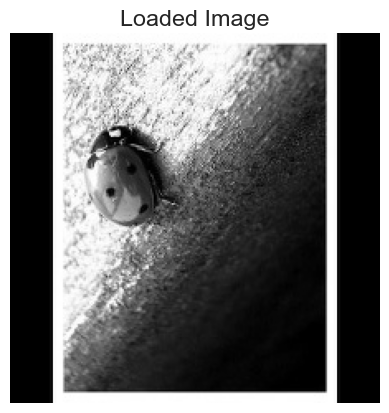

1/1 [==============================] - 0s 170ms/step


Maximum Probability:  0.99961084
Classified: Ladybird 



-------------------Individual Probability--------------------------------

BUTTERFLY : 0.02 %
DRAGONFLY : 0.01 %
GRASSHOPPER : 0.01 %
LADYBIRD : 99.96 %
MOSQUITO : 0.01 %


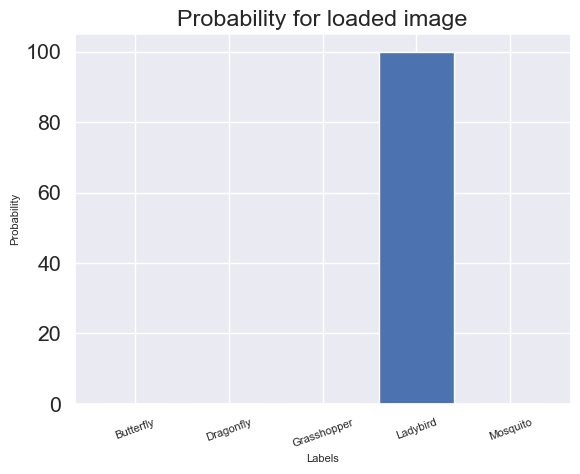


--------------------------------------------------------------------------



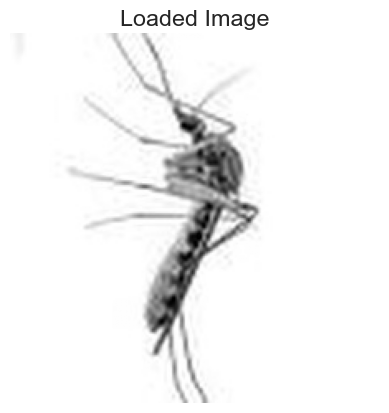

1/1 [==============================] - 0s 189ms/step


Maximum Probability:  0.9919201
Classified: Mosquito 



-------------------Individual Probability--------------------------------

BUTTERFLY : 0.0 %
DRAGONFLY : 0.54 %
GRASSHOPPER : 0.26 %
LADYBIRD : 0.0 %
MOSQUITO : 99.19 %


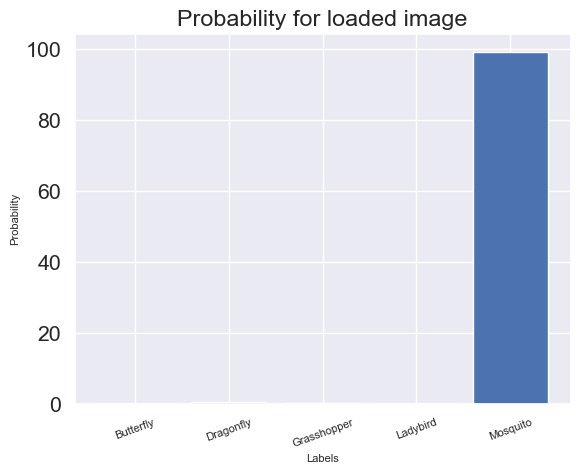


--------------------------------------------------------------------------



In [34]:
#step 19
#predict 5 random samples
model = tf.keras.models.load_model(model_dir, compile = False)
p1=predict.predict(get_data.get_random_file(preprocessed_dir+'/Butterfly'),model)
p2=predict.predict(get_data.get_random_file(preprocessed_dir+'/Dragonfly'),model)
p3=predict.predict(get_data.get_random_file(preprocessed_dir+'/Grasshopper'),model)
p4=predict.predict(get_data.get_random_file(preprocessed_dir+'/Ladybird'),model)
p5=predict.predict(get_data.get_random_file(preprocessed_dir+'/Mosquito'),model) 

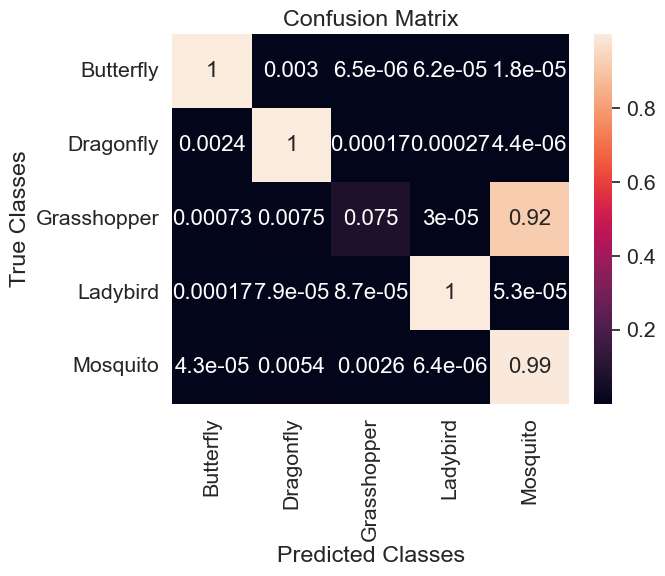

In [35]:
#step 20
conf_mat = np.array([p1[0][0:5], p2[0][0:5], p3[0][0:5], p4[0][0:5], p5[0][0:5]])
v.confusion_matrix(conf_mat)

In [36]:
#step 21
#evaluate model
model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

result = model.evaluate(image_test, label_test)
print("Loss of model is: ", result[0])
print("Accuracy of the model is: " , result[1]*100 , "%")

15/15 [==============================] - 68s 4s/step - loss: 0.4771 - accuracy: 0.8396
Loss of model is:  0.47707492113113403
Accuracy of the model is:  83.95833373069763 %
